# Exercise on Uber Marketing Analyst Driver Data

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV

C:\Users\WHUANG07\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ModuleNotFoundError: No module named 'xgboost'

## 1. Exploratory Analysis

#### 1.1 Categorical Variables

In [6]:
data = pd.read_csv('Uber Marketing Analyst DriverData.csv')
data = data.drop(['id'], axis = 1)
data.head(10)
# data.describe()

,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN
5,Strark,android web,Referral,1/18/16,1/18/16,1/22/16,Cadillac,DTS,2006.0,NaN
6,Strark,ios web,Paid,1/14/16,1/16/16,1/21/16,Toyota,Prius V,2014.0,1/23/16
7,Strark,ios web,Referral,1/26/16,2/5/16,NaN,NaN,NaN,NaN,NaN
8,Strark,NaN,Referral,1/5/16,NaN,NaN,NaN,NaN,NaN,NaN
9,Berton,ios web,Paid,1/25/16,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Check number of records
data.shape

(54681, 10)

In [8]:
# Define exploratory analysis function for categorical variable (with string type)
def _exploratory_analysis_string(column_name):
    num_null = data[column_name].isnull().sum()
    print 'Number of Missing values for '+column_name+': %d'%num_null
    print 'Frequency Table for '+column_name+' :' 
    return data[column_name].value_counts()

In [9]:
_exploratory_analysis_string('city_name')

Number of Missing values for city_name: 0
Frequency Table for city_name :


Strark     29557
Berton     20117
Wrouver     5007
Name: city_name, dtype: int64

In [10]:
_exploratory_analysis_string('signup_os')

Number of Missing values for signup_os: 6857
Frequency Table for signup_os :


ios web        16632
android web    14944
windows         6776
mac             5824
other           3648
Name: signup_os, dtype: int64

In [11]:
_exploratory_analysis_string('signup_channel')

Number of Missing values for signup_channel: 0
Frequency Table for signup_channel :


Paid        23938
Referral    17316
Organic     13427
Name: signup_channel, dtype: int64

In [12]:
_exploratory_analysis_string('vehicle_make')

Number of Missing values for vehicle_make: 41458
Frequency Table for vehicle_make :


Toyota           3219
Honda            1845
Nissan           1311
Ford              778
Hyundai           677
Chevrolet         665
Kia               584
Volkswagen        503
Dodge             393
Mercedes-Benz     348
Lexus             335
BMW               330
Mazda             292
Subaru            221
Jeep              203
Chrysler          202
Acura             190
Scion             164
Infiniti          147
Audi              144
Mitsubishi        113
GMC                89
Cadillac           86
Lincoln            70
Volvo              57
Buick              46
Saturn             30
Pontiac            30
Land Rover         20
Mini               20
Jaguar             15
Tesla              13
Suzuki             12
Fiat               11
Porsche            10
Mercury             9
Autobot             8
Saab                7
Hummer              7
Bike                6
Bicycle             5
Bentley             2
Maserati            2
Isuzu               2
Oldsmobile          1
Walker    

In [13]:
_exploratory_analysis_string('vehicle_model')

Number of Missing values for vehicle_model: 41458
Frequency Table for vehicle_model :


Civic                   689
Corolla                 688
Camry                   683
Accord                  595
Prius V                 522
Altima                  422
Prius                   369
Sentra                  330
Sonata                  259
Elantra                 255
Optima                  212
Jetta                   205
CR-V                    193
Versa                   192
RAV4                    189
Fusion                  186
3-series                163
Focus                   158
Sienna                  154
MAZDA3                  146
C-Class                 145
Malibu                  127
Passat                  120
Prius C                 118
Soul                    117
Odyssey                 113
Cruze                   109
Escape                  107
Highlander              106
Rogue                   103
                       ... 
CLK-Class                 1
Venture                   1
QX50                      1
Mountaineer               1
ML Class            

Comments:
* Here we assume all the model is the correct input (as we observe 5-Sep, which might be some error input). It could be further improved by cross-validating against external data sources.
* For the missing value, no special treatment carried out here, as for the following one-hoc encoding, it will be encoded, which assume "nan" as "one category" for categorical variable

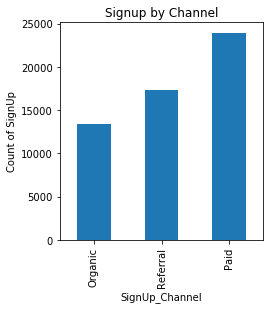

In [19]:
# Example for Histogram
import matplotlib.pyplot as plt
temp1 = data['signup_channel'].value_counts(ascending=True)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('SignUp_Channel')
ax1.set_ylabel('Count of SignUp')
ax1.set_title("Signup by Channel")
temp1.plot(kind='bar')
plt.show()

#### 1.2 Datetime Variables 
The purpose is to decide the binning for datatime variables by looking at month

In [15]:
def _check_month(column_name):
    num_null = data[column_name].isnull().sum()
    print 'Number of Missing values for '+column_name+': %d'%num_null
    temp_month = data[column_name][data[column_name].notnull()].apply(lambda x: x.split('/')[0])
    print('Frequency Table for Month of '+column_name)
    return temp_month.value_counts()

In [16]:
_check_month('signup_date')

Number of Missing values for signup_date: 0
Frequency Table for Month of signup_date


1    54681
Name: signup_date, dtype: int64

In [17]:
_check_month('bgc_date')

Number of Missing values for bgc_date: 21785
Frequency Table for Month of bgc_date


1    23513
2     9335
3       48
Name: bgc_date, dtype: int64

In [18]:
_check_month('vehicle_added_date')

Number of Missing values for vehicle_added_date: 41547
Frequency Table for Month of vehicle_added_date


1    7531
2    5560
3      43
Name: vehicle_added_date, dtype: int64

## 2. Input Data Encoding

#### 2.1 Binning the Datetime

Based on the results of Exploratory analysis for datetime variables, since all date for "signup_date" is on January, we can do the binning for every 10 days. And for "bgc_date" and "vehicle_added_date", the date are on Jan, Feb and Mar, therefore we can do the binning based on month. 

In [109]:
# Date Binning based on every ten days
data['signup_date'] = data['signup_date'][data.signup_date.notnull()].apply(lambda x: int(x.split('/')[1]))
bins = [1, 10, 20, 31]
group_names = ['first_10d', 'middle_10d', 'last_10d']
data['signup_date'] = pd.cut(data['signup_date'], bins, labels=group_names)

In [110]:
def _datetime_binning_on_Month(column_name):
    data[column_name] = data[column_name][data[column_name].notnull()].apply(lambda x: x.split('/')[0])
    print('Datetime successfully binned for '+column_name)
    
_datetime_binning_on_Month('bgc_date')
_datetime_binning_on_Month('vehicle_added_date')

Datetime successfully binned for bgc_date
Datetime successfully binned for vehicle_added_date


In [111]:
data.head(20)
# data.shape

,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,Strark,ios web,Paid,first_10d,NaN,NaN,NaN,NaN,NaN,NaN
1,Strark,windows,Paid,last_10d,NaN,NaN,NaN,NaN,NaN,NaN
2,Wrouver,windows,Organic,middle_10d,1,NaN,NaN,NaN,NaN,NaN
3,Berton,android web,Referral,last_10d,2,2,Toyota,Corolla,2016.0,2/3/16
4,Strark,android web,Referral,first_10d,1,1,Hyundai,Sonata,2016.0,NaN
5,Strark,android web,Referral,middle_10d,1,1,Cadillac,DTS,2006.0,NaN
6,Strark,ios web,Paid,middle_10d,1,1,Toyota,Prius V,2014.0,1/23/16
7,Strark,ios web,Referral,last_10d,2,NaN,NaN,NaN,NaN,NaN
8,Strark,NaN,Referral,first_10d,NaN,NaN,NaN,NaN,NaN,NaN
9,Berton,ios web,Paid,last_10d,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.2 One Hoc Encoding

In [112]:
encode_list = ['city_name', 'signup_os', 'signup_channel', 'signup_date', 'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model', 'vehicle_year']
def one_hoc_encoder(data, column_list):
    for column in column_list:
        data = pd.get_dummies(data, prefix=column, columns=[column])
    return data
data = one_hoc_encoder(data, encode_list)

In [113]:
data.columns

Index([u'first_completed_date', u'city_name_Berton', u'city_name_Strark',
       u'city_name_Wrouver', u'signup_os_android web', u'signup_os_ios web',
       u'signup_os_mac', u'signup_os_other', u'signup_os_windows',
       u'signup_channel_Organic',
       ...
       u'vehicle_year_2008.0', u'vehicle_year_2009.0', u'vehicle_year_2010.0',
       u'vehicle_year_2011.0', u'vehicle_year_2012.0', u'vehicle_year_2013.0',
       u'vehicle_year_2014.0', u'vehicle_year_2015.0', u'vehicle_year_2016.0',
       u'vehicle_year_2017.0'],
      dtype='object', length=459)

In [114]:
# assuming all the null in "first_completed_date" are those not complete the first drive, but not missing value
data.first_completed_date = data.first_completed_date.isnull()
data.first_completed_date.value_counts()

True     48544
False     6137
Name: first_completed_date, dtype: int64

In [115]:
data.head(20)

,first_completed_date,city_name_Berton,city_name_Strark,city_name_Wrouver,signup_os_android web,signup_os_ios web,signup_os_mac,signup_os_other,signup_os_windows,signup_channel_Organic,...,vehicle_year_2008.0,vehicle_year_2009.0,vehicle_year_2010.0,vehicle_year_2011.0,vehicle_year_2012.0,vehicle_year_2013.0,vehicle_year_2014.0,vehicle_year_2015.0,vehicle_year_2016.0,vehicle_year_2017.0
0,True,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,True,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,False,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,True,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,True,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,False,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,True,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,True,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,True,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Modeling

In [116]:
train, test = train_test_split(data, test_size = 0.3)
target = 'first_completed_date'
predictors = [x for x in train.columns if x not in [target, 'id']]

In [118]:
# Setup the cross-validation to avoid the overfitting
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)[:30]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print "Most important features: " 
    print feat_imp
    return alg

In [119]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence
 seed=27)


Model Report
Accuracy : 0.9375
AUC Score (Train): 0.966984


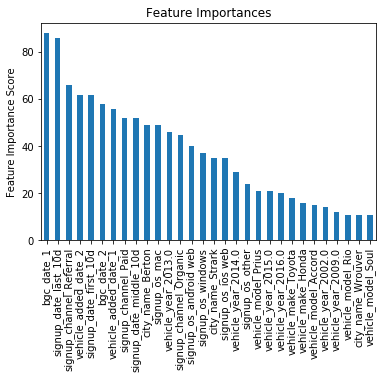

Most important features: 
bgc_date_1                 88
signup_date_last_10d       86
signup_channel_Referral    66
vehicle_added_date_2       62
signup_date_first_10d      62
bgc_date_2                 58
vehicle_added_date_1       56
signup_channel_Paid        52
signup_date_middle_10d     52
city_name_Berton           49
signup_os_mac              49
vehicle_year_2013.0        46
signup_channel_Organic     45
signup_os_android web      40
signup_os_windows          37
city_name_Strark           35
signup_os_ios web          35
vehicle_year_2014.0        29
signup_os_other            24
vehicle_model_Prius        21
vehicle_year_2015.0        21
vehicle_year_2016.0        20
vehicle_make_Toyota        18
vehicle_make_Honda         16
vehicle_model_Accord       15
vehicle_year_2002.0        14
vehicle_year_2009.0        12
vehicle_model_Rio          11
city_name_Wrouver          11
vehicle_model_Soul         11
dtype: int64


In [120]:
model = modelfit(xgb1, train, predictors, target)

In [122]:
x_test = test.drop(['first_completed_date'], axis = 1)
y_test = test.first_completed_date
print x_test.shape
print y_test.shape

(16405, 458)
(16405,)


In [130]:
y_pred = model.predict(x_test)
# pd.Series(y_pred).value_counts()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Test Set: %.2f%%" % (accuracy * 100.0))

Accuracy for Test Set: 93.12%


## 4. Parameter Tuning
Tuning the XGBoost classifier to optimize the classifier performance

####  4.1 Tune max_depth and min_child_weight
Tune these two first as it have highest impact on model outcome.

In [88]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.96089, std: 0.00220, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.96068, std: 0.00220, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.96074, std: 0.00215, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.96063, std: 0.00225, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.96022, std: 0.00214, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.96015, std: 0.00224, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.95991, std: 0.00221, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.95949, std: 0.00204, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.95963, std: 0.00225, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.95940, std: 0.00210, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.95910, std: 0.00200, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.95926, std: 0.00216, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

#### 4.2 Tune gamma

In [89]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.96062, std: 0.00216, params: {'gamma': 0.0},
  mean: 0.96055, std: 0.00221, params: {'gamma': 0.1},
  mean: 0.96058, std: 0.00219, params: {'gamma': 0.2},
  mean: 0.96054, std: 0.00222, params: {'gamma': 0.3},
  mean: 0.96056, std: 0.00212, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.9606209548003888)

#### 4.3 Tuning Regularization Parameters

In [133]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.96039, std: 0.00219, params: {'reg_alpha': 0},
  mean: 0.96039, std: 0.00219, params: {'reg_alpha': 0.001},
  mean: 0.96041, std: 0.00219, params: {'reg_alpha': 0.005},
  mean: 0.96039, std: 0.00219, params: {'reg_alpha': 0.01},
  mean: 0.96049, std: 0.00221, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 0.9604881736216975)

#### 4.4 Re-calibrate with optimized  (with reduced learning rate)


Model Report
Accuracy : 0.9347
AUC Score (Train): 0.963344


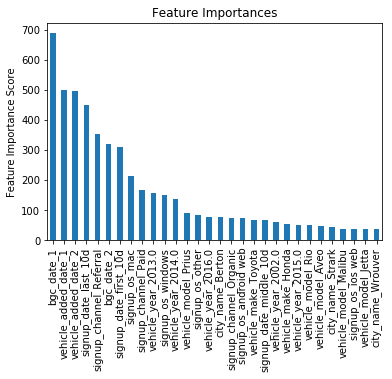

Most important features: 
bgc_date_1                 688
vehicle_added_date_1       501
vehicle_added_date_2       498
signup_date_last_10d       450
signup_channel_Referral    352
bgc_date_2                 319
signup_date_first_10d      309
signup_os_mac              214
signup_channel_Paid        169
vehicle_year_2013.0        157
signup_os_windows          150
vehicle_year_2014.0        136
vehicle_model_Prius         92
signup_os_other             83
vehicle_year_2016.0         78
city_name_Berton            77
signup_channel_Organic      75
signup_os_android web       73
vehicle_make_Toyota         69
signup_date_middle_10d      69
vehicle_year_2002.0         60
vehicle_make_Honda          56
vehicle_year_2015.0         50
vehicle_model_Rio           50
vehicle_model_Aveo          47
city_name_Strark            43
vehicle_model_Malibu        39
signup_os_ios web           38
vehicle_model_Jetta         38
city_name_Wrouver           37
dtype: int64


In [134]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha = 0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model2 = modelfit(xgb2, train, predictors, target)

It can be observed that the performance not improved a lot after been through the parameter tuning, as we tuning each parameter seperately, it might not be able to achieve the optimum configuration. Since AUC score is quite high (close to 1), and due to the time limitation, we are stastified with performance of the classifer. 

And by looking at the feature importance ranking, we will be able to provide the recommendation for the management team to come out data-driven decisions.

## 5. Prediction

In [135]:
y_pred = model2.predict(x_test)
# pd.Series(y_pred).value_counts()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Test Set: %.2f%%" % (accuracy * 100.0))

Accuracy for Test Set: 93.23%


Since the classifier is able to provide good prediction (generalize) on test data, there is no overfitting issue in the model. Thus our model is reliable and we can trust on the feature importance rankning to provide suggestions for the marketing.